In [1]:
## import packages
import numpy as np
import pandas as pd
import cPickle as pickle

import operator
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

# Description of Data Set

There are a total of 96 continuous variables in the data set. Among all the samples in the training (test) data, $29.40\%$ ($29.73\%$) of them are from positive class. The basic statistics of each variable are summarized in the file *descriptive_stats.pkl*. The pairwise correlatons are shown in *correlation.pkl*. It can be observed that some variables are highly correlated, hence, only a subset of variables should be included to guarantee a stable model. 

In [2]:
## Import datasets
df_train = pd.read_table('interview_data_train.csv', sep=',', names=['y'] + ['x{}'.format(i) for i in range(96)])
df_test = pd.read_table('interview_data_test.csv', sep=',', names=['y'] + ['x{}'.format(i) for i in range(96)])

print 'Number of variables: {}'.format(df_train.shape[1]-1)
print 'Proportion of positive class in training: {0:.2f}%'.format(df_train.y.sum()*100./df_train.shape[0])
print 'Proportion of positive class in test: {0:.2f}%'.format(df_test.y.sum()*100./df_test.shape[0])
des = df_train.describe()
des.to_pickle('descriptive_stats.pkl')
print 'Save summary Statistics for training data in {}'.format('descriptive_stats.pkl')
feature_col = ['x{}'.format(i) for i in range(96)]
corr = df_train[feature_col].corr()
corr.to_pickle('correlation.pkl')
print 'Save pairwise correlations for training data in {}'.format('correlation.pkl')

Number of variables: 96
Proportion of positive class in training: 29.40%
Proportion of positive class in test: 29.73%
Save summary Statistics for training data in descriptive_stats.pkl
Save pairwise correlations for training data in correlation.pkl


# Linear Models for Classification

Two commonly used linear models for classification are taken into consideration including logistic regression (LR) and support vector machine (SVM). Because there are 96 variables in the data set of which some strongly correlate with each other, variable selection has to be performed to obtain a parsimonious model (here $L1$ penalty is used). For both models, a grid search is conducted to find the best penalty parameter $C$. At each point of $C$, the performance measure is calculated based on five fold cross-validation. After the best penalty parameter is determined, the whole training data will be used to fit the final model. Note that a grid search over the class weight has also been explored. However, the best class weight remains to be $1:1$, hence, the results are not presented in this report. Also, no particular variable transformation is performed because almost all variables are on the same scale.  

Notice that about $29.4\%$ of samples come from positive class, suggesting moderate class-imbalance problem. As a result, the precision recall curve is used to evaluate model performance, in particular, the area under the precision recall curve (PR-AUC). However, not every model produces continuous score for each sample, e.g., SVM. In this case, the prediction accuracy (PA), i.e., proportion of samples with correct class predictions, is considered instead. 

In [3]:
## Best LR
feature_col = ['x{}'.format(i) for i in range(96)]

C = [1, .1, .01, .001]
k_fold = 5

lr_stats = {}
for c in C:
    pr_vec = []
    for k in range(k_fold):
        rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
        for trainIndex, testIndex in rs.split(df_train):
            pass
        X_Train = df_train[feature_col].iloc[trainIndex].values
        y_Train = df_train['y'].iloc[trainIndex].values
        X_Test = df_train[feature_col].iloc[testIndex].values
        y_Test = df_train['y'].iloc[testIndex].values
    
        clf = LogisticRegression(penalty='l1', C=c, n_jobs=5)
        clf.fit(X_Train, y_Train)
        p, r, th = precision_recall_curve(y_Test, clf.predict_proba(X_Test)[:, 1])
        pr_vec.append(auc(r, p))
    lr_stats[c] = np.mean(pr_vec)

## Best penalty parameter
best_c, best_prauc = sorted(lr_stats.items(), key=lambda x: x[1], reverse=True)[0]
print 'Best c {}, and the resulting PR-AUC: {}'.format(best_c, best_prauc)

## Fit the whole training data
X_train = df_train[feature_col].values
y_train = df_train['y'].astype(int).values
lr_fit = LogisticRegression(penalty='l1', C=best_c, n_jobs=5)
lr_fit.fit(X_Train, y_Train)

## Variable importance
lr_features = {key:value for key, value in zip(feature_col, abs(lr_fit.coef_.flatten())) if value > 0}
lr_features_sort = sorted(lr_features.items(), key=lambda x: x[1], reverse=True)

Best c 0.1, and the resulting PR-AUC: 0.601418435726


In [4]:
## support vector machine
C = [1, .1, .01, .001]
k_fold = 5

svm_stats = {}
for c in C:
    pa_vec = []
    for k in range(k_fold):
        rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
        for trainIndex, testIndex in rs.split(df_train):
            pass
        X_Train = df_train[feature_col].iloc[trainIndex].values
        y_Train = df_train['y'].iloc[trainIndex].values
        X_Test = df_train[feature_col].iloc[testIndex].values
        y_Test = df_train['y'].iloc[testIndex].values
    
        clf = svm.LinearSVC(penalty='l1', C=c, dual=False)
        clf.fit(X_Train, y_Train)
        accuracy = accuracy_score(y_Test, clf.predict(X_Test), normalize=True)
        pa_vec.append(accuracy)
    svm_stats[c] = np.mean(pa_vec)
    
## Best penalty parameter
best_c, best_pa = sorted(svm_stats.items(), key=lambda x: x[1], reverse=True)[0]
print 'Best c {}, and the resulting PA: {}'.format(best_c, best_pa)

## Fit the whole training data
X_train = df_train[feature_col].values
y_train = df_train['y'].astype(int).values
svm_fit = svm.LinearSVC(penalty='l1', C=best_c, dual=False)
svm_fit.fit(X_Train, y_Train)

## variable importance
svm_features = {key:value for key, value in zip(feature_col, abs(svm_fit.coef_.flatten())) if value > 0}
svm_features_sort = sorted(svm_features.items(), key=lambda x: x[1], reverse=True)

Best c 0.1, and the resulting PA: 0.762708221386


# Non-linear Models for Classification

Two commonly used ensemble methods for classification are investigated including random forest (RF) and gradient boosting machine (GBM). Among methods implementing GBM, the package LightGBM, a highly efficient gradeint boosting decision tree, is used. The training and evaluation process follow the same steps outlined in the linear models. However, the grid search finds the best tree depth for ensemble methods. One nice feature of tree ensemble methods is that variable transformation is generally not necessary as decision trees are not affected by any monotonic transformation. 

Best depth 10, and the resulting PR-AUC: 0.606328180528


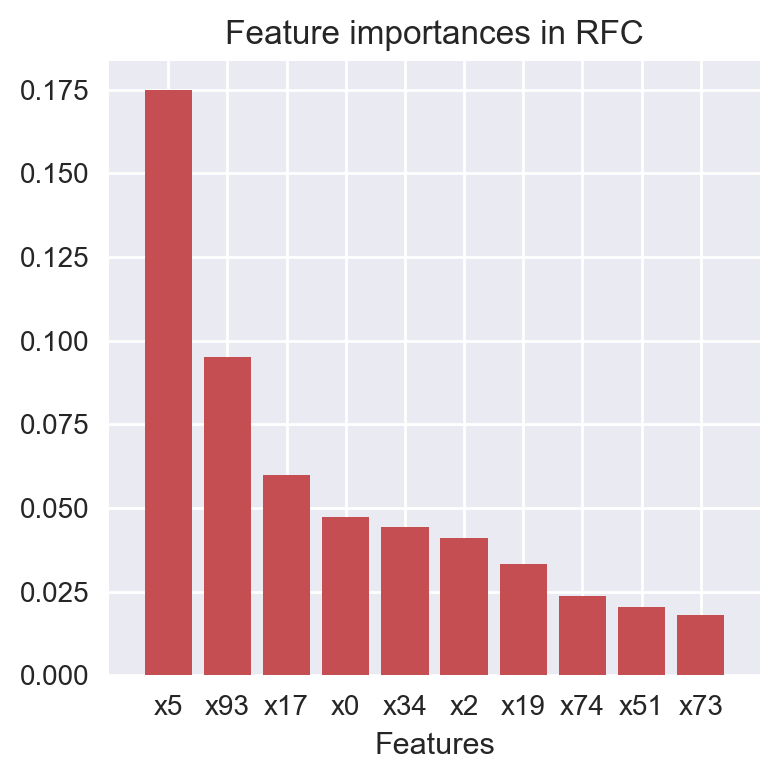

In [5]:
## Random forest
depth = [4, 6, 8, 10]
k_fold = 5

rfc_stats = {}
for d in depth:
    pr_vec = []
    for k in range(k_fold):
        rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
        for trainIndex, testIndex in rs.split(df_train):
            pass
        X_Train = df_train[feature_col].iloc[trainIndex].values
        y_Train = df_train['y'].iloc[trainIndex].values
        X_Test = df_train[feature_col].iloc[testIndex].values
        y_Test = df_train['y'].iloc[testIndex].values
    
        rfc = RandomForestClassifier(n_estimators=150, max_depth=d, n_jobs=5)
        rfc.fit(X_Train, y_Train)
        p, r, th = precision_recall_curve(y_Test, rfc.predict_proba(X_Test)[:,1])
        pr_vec.append(auc(r, p))
    rfc_stats[d] = np.mean(pr_vec)
    
## Best penalty parameter
best_d, best_prauc = sorted(rfc_stats.items(), key=lambda x: x[1], reverse=True)[0]
print 'Best depth {}, and the resulting PR-AUC: {}'.format(best_d, best_prauc)

## Fit the whole training data
X_train = df_train[feature_col].values
y_train = df_train['y'].astype(int).values
rfc_fit = RandomForestClassifier(n_estimators=150, max_depth=best_d, n_jobs=5)
rfc_fit.fit(X_train, y_train)

## variable importance
rfc_features = {key:value for key, value in zip(feature_col, rfc_fit.feature_importances_) if value > 0}
rfc_features_sort = sorted(rfc_features.items(), key=lambda x: x[1], reverse=True)
features_sorted_ten = rfc_features_sort[0:10]
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
plt.title("Feature importances in RFC")
plt.xlabel('Features')
plt.bar(range(10), [x[1] for x in features_sorted_ten], color="r", align="center")
plt.xticks(range(10), [x[0] for x in features_sorted_ten])
plt.xlim([-1, 10])
plt.tight_layout()
plt.show()

- Custom callback function for *LightGBM*

A custom callback fucntion is written to assess the *LightGBM* model using PR-AUC. 

In [6]:
from lightgbm.callback import _format_eval_result, EarlyStopException
from operator import gt, lt

## Evaluation function
def pr_auc_lgbm( y_pred, dtrain ):
    p, r, th = precision_recall_curve(dtrain.get_label(), y_pred)
    return 'pr_auc', auc(r, p), True

# custom early stopping for LightGBM
def early_stopping_one_metric(stopping_rounds, verbose=True):
    best_score = []
    best_iter = []
    best_score_list = []
    cmp_op = []

    def init(env):
        """internal function"""
        if not env.evaluation_result_list:
            raise ValueError('For early stopping, at least one dataset and eval metric is required for evaluation')

        if verbose:
            msg = "Training until validation scores don't improve for {} rounds."
            print(msg.format(stopping_rounds))

        for eval_ret in env.evaluation_result_list:
            best_iter.append(0)
            best_score_list.append(None)
            if eval_ret[3]:
                best_score.append(float('-inf'))
                cmp_op.append(gt)
            else:
                best_score.append(float('inf'))
                cmp_op.append(lt)

    def callback(env):
        """internal function"""
        if not cmp_op:
            init(env)
        for i in range(len(env.evaluation_result_list)):
            if i == 1:
                score = env.evaluation_result_list[i][2]
                if cmp_op[i](score, best_score[i]):
                    best_score[i] = score
                    best_iter[i] = env.iteration
                    best_score_list[i] = env.evaluation_result_list
                elif env.iteration - best_iter[i] >= stopping_rounds:
                    if verbose:
                        print('Early stopping, best iteration is:\n[%d]\t%s' % (
                            best_iter[i] + 1, '\t'.join([_format_eval_result(x) for x in best_score_list[i]])))
                    raise EarlyStopException(best_iter[i], best_score_list[i])
                if env.iteration == env.end_iteration - 1:
                    if verbose:
                        print('Did not meet early stopping. Best iteration is:\n[%d]\t%s' % (
                            best_iter[i] + 1, '\t'.join([_format_eval_result(x) for x in best_score_list[i]])))
                    raise EarlyStopException(best_iter[i], best_score_list[i])
    callback.order = 30
    return callback

Best depth 8, and the resulting PR-AUC: 0.620324194747


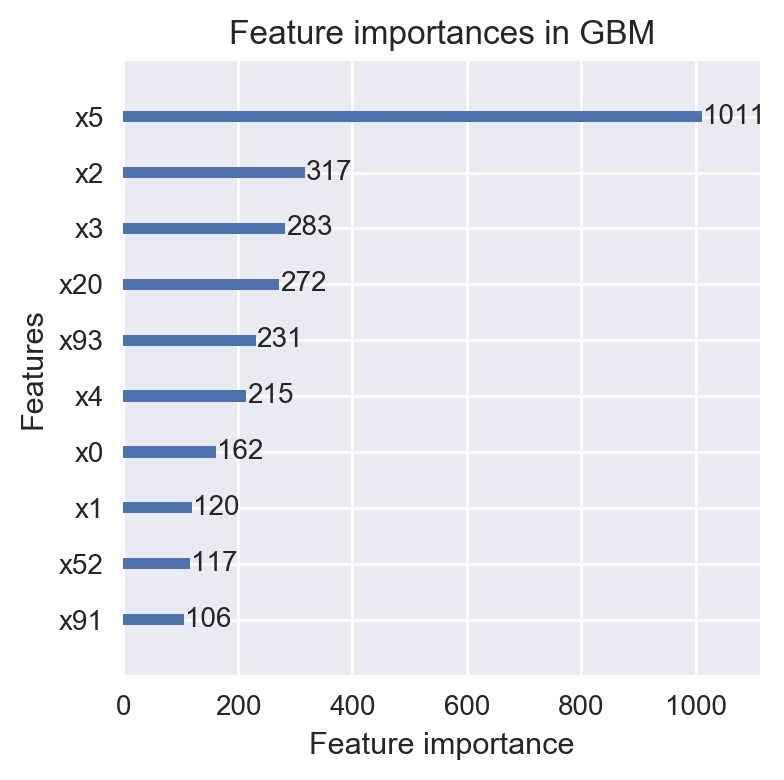

In [7]:
## LightGBM
depth = [4, 6, 8, 10]
k_fold = 5

lgb_stats = {}
for d in depth:
    pr_vec = []
    params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc',
                'max_depth': d, 'num_leaves': int(2 ** d * 0.8), 'verbose': 0, 'min_data_in_leaf': 50,
                'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5}
    
    for k in range(k_fold):
        rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=k)
        for trainIndex, testIndex in rs.split(df_train):
            pass
        X_Train = df_train[feature_col].iloc[trainIndex].values
        y_Train = df_train['y'].iloc[trainIndex].values
        X_Test = df_train[feature_col].iloc[testIndex].values
        y_Test = df_train['y'].iloc[testIndex].values
        lgb_train = lgb.Dataset(data=X_Train, label=y_Train, feature_name=feature_col, free_raw_data=False)
        lgb_test = lgb.Dataset(X_Test, y_Test, reference=lgb_train, feature_name=feature_col, free_raw_data=False)
        
        
        gbm = lgb.train(params, train_set=lgb_train, num_boost_round=200, valid_sets=lgb_test, feature_name=feature_col, 
                        early_stopping_rounds=10, verbose_eval=None, feval=pr_auc_lgbm)
        pr_vec.append(gbm.best_score['valid_0']['pr_auc'])
    lgb_stats[d] = np.mean(pr_vec)
    
## Best penalty parameter
best_d, best_prauc = sorted(lgb_stats.items(), key=lambda x: x[1], reverse=True)[0]
print 'Best depth {}, and the resulting PR-AUC: {}'.format(best_d, best_prauc)

## Fit the whole training data
X_train = df_train[feature_col].iloc[trainIndex].values
y_train = df_train['y'].iloc[trainIndex].values
X_test = df_train[feature_col].iloc[testIndex].values
y_test = df_train['y'].iloc[testIndex].values
parameters = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc',
                'max_depth': best_d, 'num_leaves': int(2 ** best_d * 0.8), 'verbose': 0, 'min_data_in_leaf': 50,
                'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5}
lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=feature_col, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, feature_name=feature_col, free_raw_data=False)
gbm_fit = lgb.train(parameters, train_set=lgb_train, num_boost_round=200, valid_sets=lgb_test, feature_name=feature_col, 
                early_stopping_rounds=10, verbose_eval=None, feval=pr_auc_lgbm)

## variable importance
lgb_features = {key:value for key, value in zip(feature_col, gbm_fit.feature_importance()) if value > 0}
lgb_features_sort = sorted(lgb_features.items(), key=lambda x: x[1], reverse=True)
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
lgb.plot_importance(gbm_fit, ax=ax, max_num_features=10, title='Feature importances in GBM')
plt.tight_layout()

# Model Evaluation on Testing Data

For the three models whose PR-AUC is available (LR, RF, and GBM), GBM trained with a $max\_depth$ of 8 results in the largest PR-AUC (0.616). However, as displayed in the Figure *PR-AUC-models.png*, the PR-AUCs of the three models do **NOT** significantly differ from each other. Similarly, the Figure *PA-models.png* shows that the prediction accuracy for all the models considered is approximately the same. The similar model performance could be due to the fact that all the models are able to pick the most important predictors such as $x_5$, $x_2$, and $x_{93}$. Also, by imposing $L1$ penalty, highly correlated features would not be included in the final model for linear classifiers. 

The conclusion of this report is: 

- for the given data sets, the two ensemble methods (i.e., RF and GBM) produce similar results (PR-AUC and prediction accuracy) as the two linear models (LR and SVM) with $L1$ penalty. 

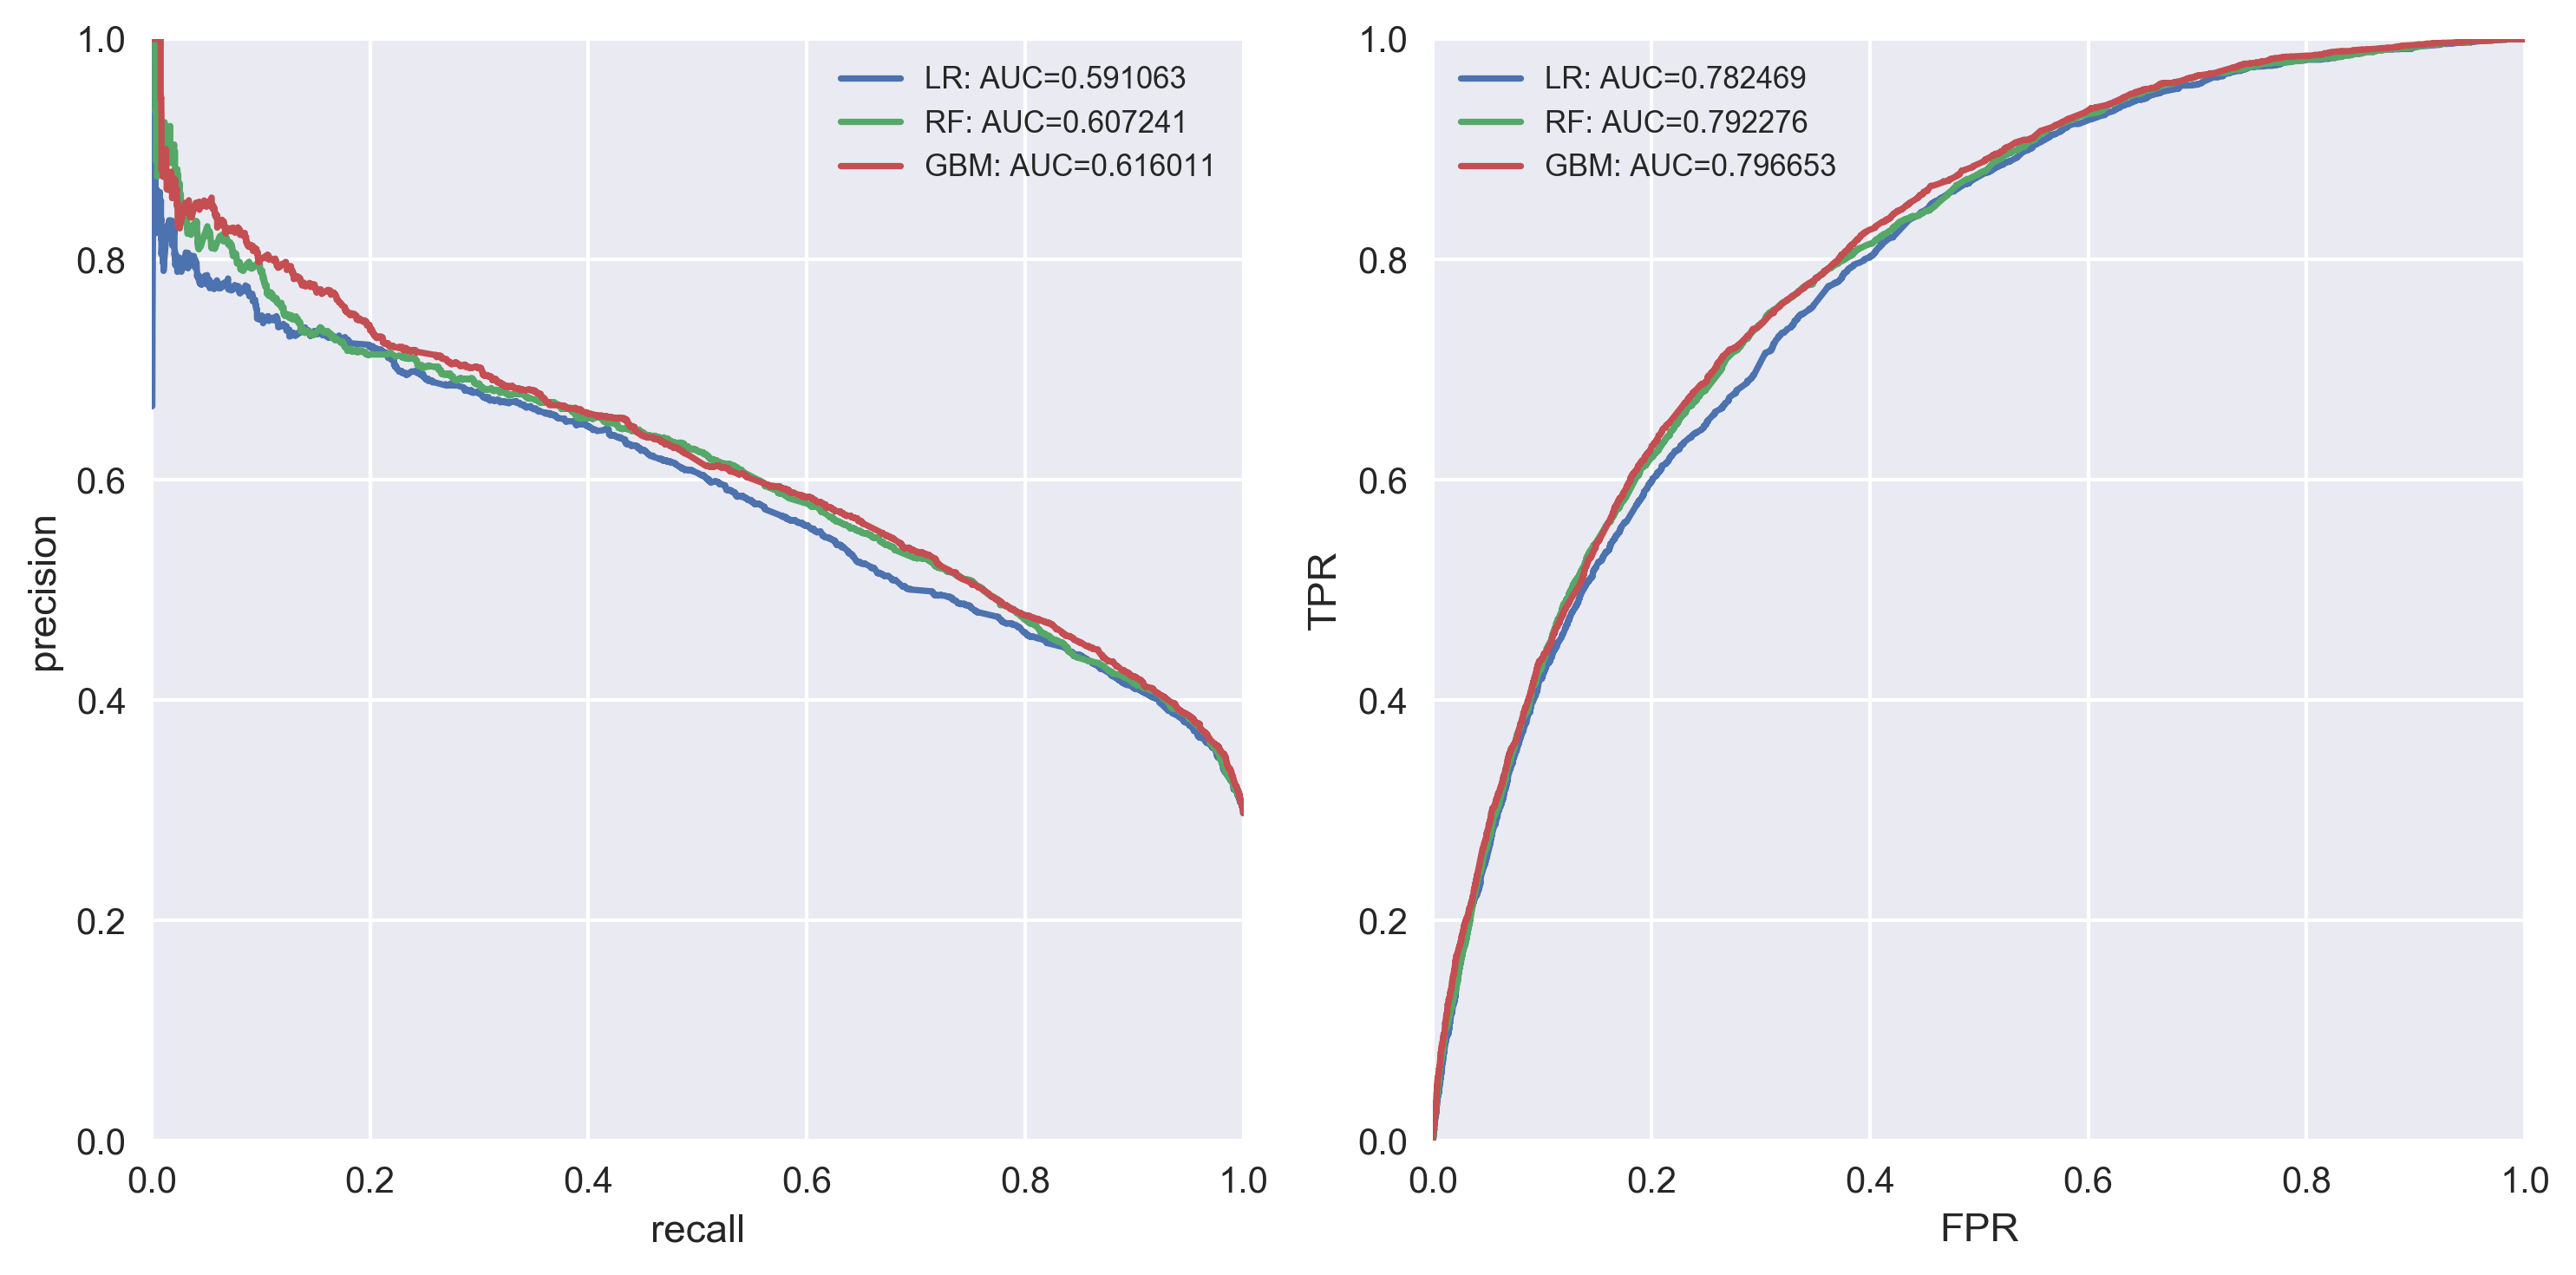

In [8]:
## PR curve and ROC
df_test['lr_score'] = lr_fit.predict_proba(df_test[feature_col].values)[:, 1]
df_test['rfc_score'] = rfc_fit.predict_proba(df_test[feature_col].values)[:,1]
df_test['gbm_score'] = gbm_fit.predict(df_test[feature_col].values)

f, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
p0, r0, th0 = precision_recall_curve(df_test['y'].astype(int).values, df_test['lr_score'])
ax[0].plot(r0, p0, label='LR: AUC={:.6f}'.format(auc(r0, p0)))
p1, r1, th1 = precision_recall_curve(df_test['y'].astype(int).values, df_test['rfc_score'])
ax[0].plot(r1, p1, label='RF: AUC={:.6f}'.format(auc(r1, p1)))
p2, r2, th2 = precision_recall_curve(df_test['y'].astype(int).values, df_test['gbm_score'])
ax[0].plot(r2, p2, label='GBM: AUC={:.6f}'.format(auc(r2, p2)))

fpr0, tpr0, th0 = roc_curve(df_test['y'].astype(int).values, df_test['lr_score'])
ax[1].plot(fpr0, tpr0, label='LR: AUC={:.6f}'.format(auc(fpr0, tpr0)))
fpr1, tpr1, th1 = roc_curve(df_test['y'].astype(int).values, df_test['rfc_score'])
ax[1].plot(fpr1, tpr1, label='RF: AUC={:.6f}'.format(auc(fpr1, tpr1)))
fpr2, tpr2, th2 = roc_curve(df_test['y'].astype(int).values, df_test['gbm_score'])
ax[1].plot(fpr2, tpr2, label='GBM: AUC={:.6f}'.format(auc(fpr2, tpr2)))

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].set_xlabel('recall')
ax[0].set_ylabel('precision')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
ax[0].legend(loc='best', fontsize='small')
ax[1].legend(loc='best', fontsize='small')
f.set_tight_layout(1)
f.savefig('PR-AUC-models.png')

[('GBM', 0.7613127078213098), ('RF', 0.7587104235940436), ('LR', 0.7576261384993495), ('SVM', 0.7574092814804105)]


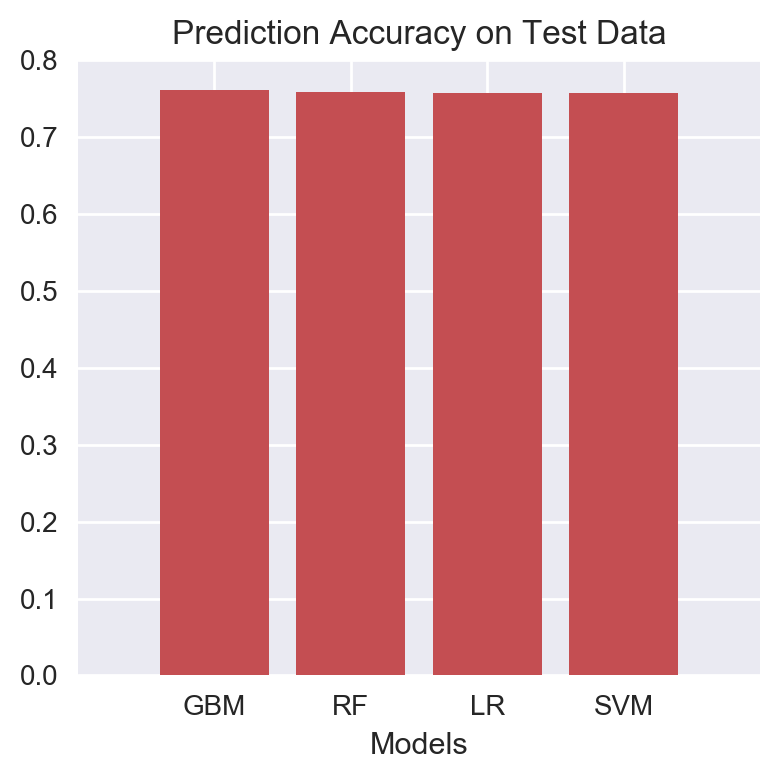

In [9]:
## Prediction accuracy
y_true = df_test['y'].astype(int).values
lr_pa = accuracy_score(y_true, lr_fit.predict(df_test[feature_col].values), normalize=True)
svm_pa = accuracy_score(y_true, svm_fit.predict(df_test[feature_col].values), normalize=True)
rfc_pa = accuracy_score(y_true, rfc_fit.predict(df_test[feature_col].values), normalize=True) 
gbm_pa = accuracy_score(y_true, np.where(gbm_fit.predict(df_test[feature_col].values)>0.5, 1, 0), normalize=True)

pa_res = {key:val for key, val in zip(['LR', 'SVM', 'RF', 'GBM'], [lr_pa, svm_pa, rfc_pa, gbm_pa])}
pa_res_sort = sorted(pa_res.items(), key=lambda x: x[1], reverse=True)
print pa_res_sort
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
plt.title("Prediction Accuracy on Test Data")
plt.xlabel('Models')
plt.bar(range(4), [x[1] for x in pa_res_sort], color="r", align="center")
plt.xticks(range(4), [x[0] for x in pa_res_sort]) 
plt.xlim([-1, 4])
plt.tight_layout()
plt.show()
f.savefig('PA-models.png')